In [1]:
from astropy.io import ascii
import pylab as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.interpolate import interp1d

%matplotlib inline
import pystan
import numpy as np

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [ ]:
GP_code = """// Sample from Gaussian process
// Fixed covar function: eta_sq=1, rho_sq=1, sigma_sq=0.1

data {
  int<lower=1> N;
  real x[N];
  real eta_sq;
  real inv_rho_sq;
  real sigma_sq;
  
}
transformed data {
  vector[N] mu;
  cov_matrix[N] Sigma;
  real<lower=0.0> rho_sq;
  rho_sq <- inv(inv_rho_sq);
  for (i in 1:N) 
    mu[i] <- 0;
  for (i in 1:N) 
    for (j in 1:N)
      Sigma[i,j] <- eta_sq * exp(-rho_sq * pow(x[i] - x[j],2)) + if_else(i==j, sigma_sq, 0.0);
}
parameters {
  vector[N] y;
}
model {
  y ~ multi_normal(mu,Sigma);
}"""

In [ ]:
z=np.arange(0,10,0.1)

In [ ]:
GP_data={'N': 100,
         'x': z,
         'eta_sq': 0.1,
         'inv_rho_sq':1,
         'sigma_sq':0.1}

In [ ]:
fit = pystan.stan(model_code=GP_code, data=GP_data,
                  iter=1000, chains=4)

In [ ]:
samps=fit.extract(permuted=False, inc_warmup=False)

In [ ]:
samps.shape

In [2]:
import pylab as plt
%matplotlib inline


In [ ]:
for i in range(0,100,10):
    plt.plot(z,samps[i,0,0:-1])

In [3]:
M82 = ascii.read("/Users/pdh21/astrodata/COSMOS/WP5_COSMOS_XIDplus_P2/M82_template_norm.sed")
arp220 = ascii.read("/Users/pdh21/astrodata/COSMOS/WP5_COSMOS_XIDplus_P2/Arp220_template_norm.sed")

In [4]:
class FilterDefinition:
    def __init__(self):
        """
        Placeholder for the filter definition information.
        """
        self.name = None
        self.wavelength = None
        self.transmision = None

class FilterFile:
    def __init__(self, file='FILTER.RES.v8.R300'):
        """
        Read a EAZY (HYPERZ) filter file.
        """
        fp = open(file)
        lines = fp.readlines()
        fp.close()
        
        filters = []
        wave = []
        for line in lines:
            try:
                lspl = np.cast[float](line.split())
                wave.append(lspl[1])
                trans.append(lspl[2])
            except (ValueError,IndexError):
                if len(wave) > 0:
                    new_filter = FilterDefinition()
                    new_filter.name = header
                    new_filter.wavelength = np.cast[float](wave)
                    new_filter.transmission = np.cast[float](trans)
                    filters.append(new_filter)
                    
                header = ' '.join(line.split()[1:])
                wave = []
                trans = []
        # last one
        new_filter = FilterDefinition()
        new_filter.name = header
        new_filter.wavelength = np.cast[float](wave)
        new_filter.transmission = np.cast[float](trans)
        filters.append(new_filter)
           
        self.filters = filters
        self.NFILT = len(filters)
    
    def names(self):
        """
        Print the filter names.
        """
        for i in range(len(self.filters)):
            print '%5d %s' %(i+1, self.filters[i].name)
    
    def write(self, file='xxx.res', verbose=True):
        """
        Dump the filter information to a filter file.
        """
        fp = open(file,'w')
        for filter in self.filters:
            fp.write('%6d %s\n' %(len(filter.wavelength), filter.name))
            for i in range(len(filter.wavelength)):
                fp.write('%-6d %.5e %.5e\n' %(i+1, filter.wavelength[i], filter.transmission[i]))
        
        fp.close()
        if verbose:
            print 'Wrote <%s>.' %(file)
            
    def search(self, search_string, case=True, verbose=True):
        """ 
        Search filter names for `search_string`.  If `case` is True, then
        match case.
        """
        import re
        
        if not case:
            search_string = search_string.upper()
        
        matched = []
        
        for i in range(len(self.filters)):
            filt_name = self.filters[i].name
            if not case:
                filt_name = filt_name.upper()
                
            if re.search(search_string, filt_name) is not None:
                if verbose:
                    print '%5d %s' %(i+1, self.filters[i].name)
                matched.append(i)
        
        return np.array(matched)

In [5]:
filter=FilterFile(file="/Users/pdh21/astrodata/COSMOS/WP5_COSMOS_XIDplus_P2/filters.res")

In [6]:
SPIRE_250=filter.filters[215]
SPIRE_350=filter.filters[216]
SPIRE_500=filter.filters[217]

In [7]:
def fnu_filt(sed_fnu,filt_nu,filt_trans,nu_0,sed_f0):
    #f_nu=Int(d_nu f_nu R_nu)/Int(d_nu (nu/nu_0)^-1 R_nu)
    numerator=np.trapz(sed_fnu*filt_trans,x=filt_nu)
    denominator=np.trapz(filt_trans*(nu_0/filt_nu),x=filt_nu)
    
    #colour correction
    #C=Int(d_nu (nu/nu_0)^-1 R_nu)/Int(d_nu (f(nu)/f(nu_0)) R_nu)
    C_num=np.trapz(filt_trans*(nu_0/filt_nu),x=filt_nu)
    C_denom=np.trapz(filt_trans*(sed_fnu/sed_f0),x=filt_nu)

    
    return (numerator/denominator)*(C_num/C_denom)


In [8]:

flux=arp220['col2']*(arp220['col1']**2)/3E8
wave=arp220['col1']/1E4
S_250=[]
S_350=[]
S_500=[]
red=[]
for z in np.arange(0,3,0.05):
    sed=interp1d((z+1.0)*wave, flux)
    S_250.append(fnu_filt(sed(SPIRE_250.wavelength/1E4),3E8/(SPIRE_250.wavelength/1E10),SPIRE_250.transmission,3E8/250E-6,sed(250.0)))
    S_350.append(fnu_filt(sed(SPIRE_350.wavelength/1E4),3E8/(SPIRE_350.wavelength/1E10),SPIRE_350.transmission,3E8/350E-6,sed(350.0)))
    S_500.append(fnu_filt(sed(SPIRE_500.wavelength/1E4),3E8/(SPIRE_500.wavelength/1E10),SPIRE_500.transmission,3E8/500E-6,sed(500.0)))
    red.append(z)
    
    
flux=M82['col2']*((M82['col1']/1E10)**2)/3E8
wave=M82['col1']/1E4
S_250_M82=[]
S_350_M82=[]
S_500_M82=[]
red=[]
for z in np.arange(0,3,0.05):
    sed=interp1d((z+1.0)*wave, flux,kind='slinear')
    S_250_M82.append(fnu_filt(sed(SPIRE_250.wavelength/1E4),3E8/(SPIRE_250.wavelength/1E10),SPIRE_250.transmission,3E8/250E-6,sed(250.0)))
    S_350_M82.append(fnu_filt(sed(SPIRE_350.wavelength/1E4),3E8/(SPIRE_350.wavelength/1E10),SPIRE_350.transmission,3E8/350E-6,sed(350.0)))
    S_500_M82.append(fnu_filt(sed(SPIRE_500.wavelength/1E4),3E8/(SPIRE_500.wavelength/1E10),SPIRE_500.transmission,3E8/500E-6,sed(500.0)))
    red.append(z)

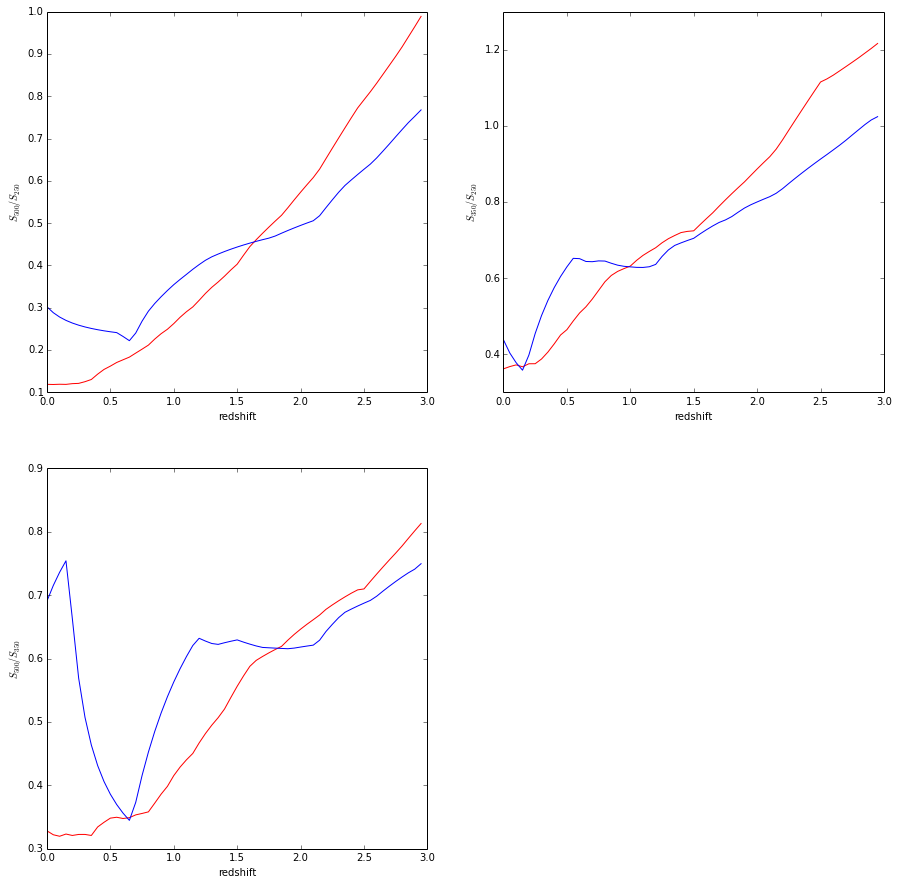

In [9]:
fig2 = plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.plot(red,np.array(S_500)/np.array(S_250), 'r')
plt.plot(red,np.array(S_500_M82)/np.array(S_250_M82),'b')
plt.xlabel('redshift')
plt.ylabel(r'$S_{500}/S_{250}$')
plt.subplot(2,2,2)
plt.plot(red,np.array(S_350)/np.array(S_250), 'r')
plt.plot(red,np.array(S_350_M82)/np.array(S_250_M82),'b')
plt.xlabel('redshift')
plt.ylabel(r'$S_{350}/S_{250}$')
plt.subplot(2,2,3)
plt.plot(red,np.array(S_500)/np.array(S_350), 'r')
plt.plot(red,np.array(S_500_M82)/np.array(S_350_M82),'b')
plt.xlabel('redshift')
plt.ylabel(r'$S_{500}/S_{350}$')

# $S_{250}/S_{500}$ GP fit

In [ ]:
samps_arp220=fit_arp_250_500.extract(permuted=False, inc_warmup=False)
samps_M82=fit_M82_250_500.extract(permuted=False, inc_warmup=False)

In [ ]:
plt.hist(samps_arp220[:,:,0].flatten(),bins=np.arange(0,30,1),alpha=0.5)
plt.hist(samps_M82[:,:,0].flatten(),bins=np.arange(0,30,1),alpha=0.5)
plt.xlabel(r'$\eta^2$')

In [ ]:
plt.hist(samps_arp220[:,0,1].flatten(),bins=np.arange(0,30,1),alpha=0.5)
plt.hist(samps_M82[:,0,1].flatten(),bins=np.arange(0,30,1),alpha=0.5)
plt.xlabel(r'$l^2$')

# $S_{350}/S_{500}$ GP fit

In [ ]:
GP_data={'N': len(red),
         'x': red,
         'y':np.array(S_350)/np.array(S_500)}
fit_arp_350_500 = pystan.stan(model_code=GP_code, data=GP_data,
                  iter=1000, chains=4)
GP_data={'N': len(red),
         'x': red,
         'y':np.array(S_350_M82)/np.array(S_500_M82)}
fit_M82_350_500 = pystan.stan(model_code=GP_code, data=GP_data,
                  iter=1000, chains=4)

In [ ]:
samps_arp220=fit_arp_350_500.extract(permuted=False, inc_warmup=False)
samps_M82=fit_M82_350_500.extract(permuted=False, inc_warmup=False)

In [ ]:
plt.hist(samps_arp220[:,:,0].flatten(),bins=np.arange(0,30,1),alpha=0.5)
plt.hist(samps_M82[:,:,0].flatten(),bins=np.arange(0,30,1),alpha=0.5)
plt.xlabel(r'$\eta^2$')

In [ ]:
plt.hist(samps_arp220[:,0,1].flatten(),bins=np.arange(0,30,1),alpha=0.5)
plt.hist(samps_M82[:,0,1].flatten(),bins=np.arange(0,30,1),alpha=0.5)
plt.xlabel(r'$l^2$')

# $S_{250}/S_{350}$ GP fit

In [ ]:
GP_data={'N': len(red),
         'x': red,
         'y':np.array(S_250)/np.array(S_350)}
fit_arp_250_350 = pystan.stan(model_code=GP_code, data=GP_data,
                  iter=1000, chains=4)
GP_data={'N': len(red),
         'x': red,
         'y':np.array(S_250_M82)/np.array(S_350_M82)}
fit_M82_250_350 = pystan.stan(model_code=GP_code, data=GP_data,
                  iter=1000, chains=4)

In [ ]:
samps_arp220=fit_arp_250_350.extract(permuted=False, inc_warmup=False)
samps_M82=fit_M82_250_350.extract(permuted=False, inc_warmup=False)

In [ ]:
plt.hist(samps_arp220[:,:,0].flatten(),bins=np.arange(0,30,1),alpha=0.5)
plt.hist(samps_M82[:,:,0].flatten(),bins=np.arange(0,30,1),alpha=0.5)
plt.xlabel(r'$\eta^2$')

In [ ]:
plt.hist(samps_arp220[:,0,1].flatten(),bins=np.arange(0,30,1),alpha=0.5)
plt.hist(samps_M82[:,0,1].flatten(),bins=np.arange(0,30,1),alpha=0.5)
plt.xlabel(r'$l^2$')

# GP fit and sim using Arp220 as prior

In [12]:
zpred=np.arange(0,5,0.5)

In [13]:
GP_code = """/// Fit a Gaussian process's hyperparameters
// for squared exponential prior

data {
  int<lower=1> N;
  vector[N] z;
  vector[N] S500_S350;
  vector[N] S500_S250;
  vector[N] S350_S250;
  int<lower=1> Npred;
  vector[Npred] zpred;

  
}
transformed data {
  vector[N+Npred] mu;
  for (i in 1:N+Npred) 
    mu[i] <- 0;
}
parameters {
  real<lower=0> eta_sq;
  real<lower=0> rho_sq;
  real<lower=0> sigma_sq;
  vector[Npred] S500_S350_pred;
  vector[Npred] S500_S250_pred;
  vector[Npred] S350_S250_pred;
  }
model {
  matrix[N+Npred,N+Npred] Sigma;
  matrix[N+Npred,N+Npred] L;
  vector[N+Npred] zall;
  vector[N+Npred] S500_S350_all;
  vector[N+Npred] S500_S250_all;
  vector[N+Npred] S350_S250_all;

  for (k in 1:N) {
    zall[k] <- z[k];
    S500_S350_all[k] <- S500_S350[k];
    S500_S250_all[k] <- S500_S250[k];
    S350_S250_all[k] <- S350_S250[k];
  }
  for (k in 1:Npred) {
    zall[k+N] <- zpred[k];
    S500_S350_all[k+N] <- S500_S350_pred[k];
    S500_S250_all[k+N] <- S500_S250_pred[k];
    S350_S250_all[k+N] <- S350_S250_pred[k];
  }

  // off-diagonal elements
  for (i in 1:(N+Npred-1)) {
    for (j in (i+1):N+Npred) {
      Sigma[i,j] <- eta_sq * exp(-rho_sq * pow(zall[i] - zall[j],2));
      Sigma[j,i] <- Sigma[i,j];
    }
  }

  // diagonal elements
  for (k in 1:N+Npred)
    Sigma[k,k] <- eta_sq + sigma_sq; // + jitter
    
  L <- cholesky_decompose(Sigma);
  eta_sq ~ cauchy(0,5);
  rho_sq ~ cauchy(0,5);
  sigma_sq ~ cauchy(0,5);
  
  S500_S350_all ~ multi_normal_cholesky(mu,L);
  S500_S250_all ~ multi_normal_cholesky(mu,L);
  S350_S250_all ~ multi_normal_cholesky(mu,L);

  
}"""

In [ ]:
GP_data={'N': len(red),
         'z': red,
         'S500_S350':np.array(S_500)/np.array(S_350),
         'S500_S250':np.array(S_500)/np.array(S_250),
         'S350_S250':np.array(S_350)/np.array(S_250),
         'Npred': zpred.size,
         'zpred':zpred}
fit_ = pystan.stan(model_code=GP_code, data=GP_data,
                  iter=1000, chains=4)

In [ ]:
fit_.constrained_param_names()

In [ ]:
stan_fit=fit_.extract(permuted=False, inc_warmup=False)
stan_fit.shape

In [ ]:
import triangle

figure = triangle.corner(stan_fit[:,:,0:3].reshape(2000,3), labels=[r"$\eta^2$", r"$\rho^2$", r"$\sigma^2$"],
                         quantiles=[0.16, 0.5, 0.84],
                         show_titles=True, title_args={"fontsize": 12})

In [ ]:
S500_S350_pred=np.empty((zpred.size,3))
S500_S250_pred=np.empty((zpred.size,3))
S350_S250_pred=np.empty((zpred.size,3))
for i in range(0,zpred.size):
    S500_S350_pred[i,:]=np.percentile(stan_fit[:,:,3+i].reshape(2000,1),q=(16.0,50.0,84.0))
    S500_S250_pred[i,:]=np.percentile(stan_fit[:,:,3+i+zpred.size].reshape(2000,1),q=(16,50,84))
    S350_S250_pred[i,:]=np.percentile(stan_fit[:,:,3+i+2*zpred.size].reshape(2000,1),q=(16,50,84))


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True,figsize=(10,10))

ax1.fill_between(zpred, S500_S350_pred[:,0],S500_S350_pred[:,2],alpha=0.5)
ax1.plot(red,np.array(S_500)/np.array(S_350),'r')
ax1.set_ylabel(r'$S_{500}/S_{350}$')

ax2.fill_between(zpred, S500_S250_pred[:,0],S500_S250_pred[:,2],alpha=0.5)
ax2.plot(red,np.array(S_500)/np.array(S_250),'r')
ax2.set_ylabel(r'$S_{500}/S_{250}$')

ax3.fill_between(zpred, S350_S250_pred[:,0],S350_S250_pred[:,2],alpha=0.5)
ax3.plot(red,np.array(S_350)/np.array(S_250),'r')
ax3.set_ylabel(r'$S_{350}/S_{250}$')
ax3.set_xlabel('z')

# GP fit and sim using Arp220 and M82 as prior

In [14]:
GP_data={'N': 2*len(red),
         'z': red+red,
         'S500_S350':np.append(np.array(S_500)/np.array(S_350),np.array(S_500_M82)/np.array(S_350_M82)),
         'S500_S250':np.append(np.array(S_500)/np.array(S_250),np.array(S_500_M82)/np.array(S_250_M82)),
         'S350_S250':np.append(np.array(S_350)/np.array(S_250),np.array(S_350_M82)/np.array(S_250_M82)),
         'Npred': zpred.size,
         'zpred':zpred}
fit_ = pystan.stan(model_code=GP_code, data=GP_data,
                  iter=1000, chains=4)

/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/usr

In [15]:
stan_fit=fit_.extract(permuted=False, inc_warmup=False)
stan_fit.shape

(500, 4, 34)

Quantiles:
[(0.16, 0.30904832333908305), (0.5, 0.50118889781184972), (0.84, 0.90235177179008796)]
Quantiles:
[(0.16, 0.26050651084042364), (0.5, 0.35164628395333403), (0.84, 0.45826509124364484)]
Quantiles:

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':



[(0.16, 0.0040544226924616256), (0.5, 0.0043946415870594084), (0.84, 0.0047600285085041775)]


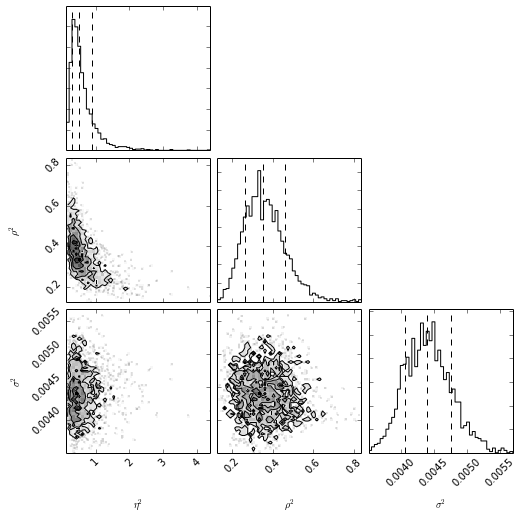

In [17]:
import triangle
figure = triangle.corner(stan_fit[:,:,0:3].reshape(2000,3), labels=[r"$\eta^2$", r"$\rho^2$", r"$\sigma^2$"],
                         quantiles=[0.16, 0.5, 0.84],
                         show_titles=True, title_args={"fontsize": 12})

In [18]:
S500_S350_pred=np.empty((zpred.size,3))
S500_S250_pred=np.empty((zpred.size,3))
S350_S250_pred=np.empty((zpred.size,3))
for i in range(0,zpred.size):
    S500_S350_pred[i,:]=np.percentile(stan_fit[:,:,3+i].reshape(2000,1),q=(16.0,50.0,84.0))
    S500_S250_pred[i,:]=np.percentile(stan_fit[:,:,3+i+zpred.size].reshape(2000,1),q=(16,50,84))
    S350_S250_pred[i,:]=np.percentile(stan_fit[:,:,3+i+2*zpred.size].reshape(2000,1),q=(16,50,84))


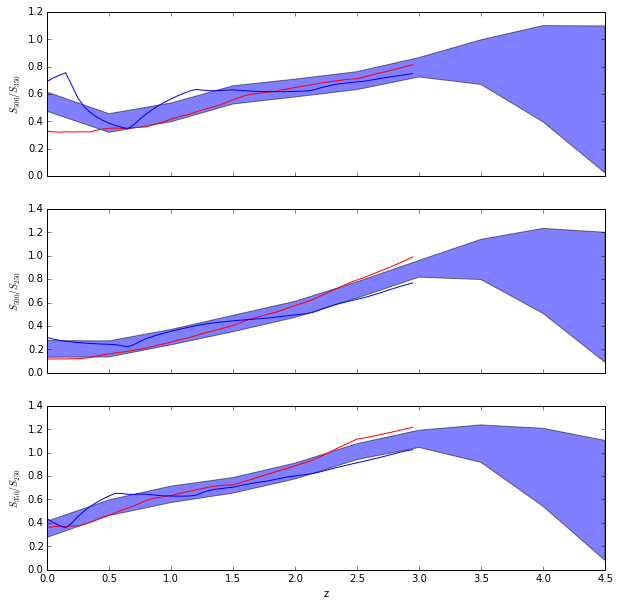

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True,figsize=(10,10))

ax1.fill_between(zpred, S500_S350_pred[:,0],S500_S350_pred[:,2],alpha=0.5)
ax1.plot(red,np.array(S_500)/np.array(S_350),'r')
ax1.plot(red,np.array(S_500_M82)/np.array(S_350_M82),'b')
ax1.set_ylabel(r'$S_{500}/S_{350}$')

ax2.fill_between(zpred, S500_S250_pred[:,0],S500_S250_pred[:,2],alpha=0.5)
ax2.plot(red,np.array(S_500)/np.array(S_250),'r')
ax2.plot(red,np.array(S_500_M82)/np.array(S_250_M82),'b')

ax2.set_ylabel(r'$S_{500}/S_{250}$')

ax3.fill_between(zpred, S350_S250_pred[:,0],S350_S250_pred[:,2],alpha=0.5)
ax3.plot(red,np.array(S_350)/np.array(S_250),'r')
ax3.plot(red,np.array(S_350_M82)/np.array(S_250_M82),'b')

ax3.set_ylabel(r'$S_{350}/S_{250}$')
ax3.set_xlabel('z')

In [20]:
import pickle
with open('./arp220_m82_GP_prior.pkl', 'wb') as f:
    pickle.dump({'zpred':zpred,'S500_S350_pred':S500_S350_pred[:,1],'S500_S250_pred':S500_S250_pred[:,1],'S350_S250_pred':S350_S250_pred[:,1]},f)

# Better GP param priors

In [ ]:
GP_code = """/// Fit a Gaussian process's hyperparameters
// for squared exponential prior

data {
  int<lower=1> N;
  vector[N] z;
  vector[N] S500_S350;
  vector[N] S500_S250;
  vector[N] S350_S250;
  int<lower=1> Npred;
  real<lower=0> eta_sq;
  real<lower=0> rho_sq;
  real<lower=0> sigma_sq;

  
}
transformed data {
  vector[N+Npred] mu;
  for (i in 1:N+Npred) 
    mu[i] <- 1;
}
parameters {

  vector<lower=0.0>[Npred] S500_S350_pred;
  vector<lower=0.0>[Npred] S500_S250_pred;
  vector<lower=0.0>[Npred] S350_S250_pred;
  vector<lower=0.0,upper=3>[Npred] zpred;
  }
model {
  matrix[N+Npred,N+Npred] Sigma;
  matrix[N+Npred,N+Npred] L;
  vector[N+Npred] zall;
  vector[N+Npred] S500_S350_all;
  vector[N+Npred] S500_S250_all;
  vector[N+Npred] S350_S250_all;

  for (k in 1:N) {
    zall[k] <- z[k];
    S500_S350_all[k] <- S500_S350[k];
    S500_S250_all[k] <- S500_S250[k];
    S350_S250_all[k] <- S350_S250[k];
  }
  for (k in 1:Npred) {
    zall[k+N] <- zpred[k];
    S500_S350_all[k+N] <- S500_S350_pred[k];
    S500_S250_all[k+N] <- S500_S250_pred[k];
    S350_S250_all[k+N] <- S350_S250_pred[k];
  }

  // off-diagonal elements
  for (i in 1:(N+Npred-1)) {
    for (j in (i+1):N+Npred) {
      Sigma[i,j] <- eta_sq * exp(-rho_sq * pow(zall[i] - zall[j],2));
      Sigma[j,i] <- Sigma[i,j];
    }
  }

  // diagonal elements
  for (k in 1:N+Npred)
    Sigma[k,k] <- eta_sq + sigma_sq; // + jitter
    
  L <- cholesky_decompose(Sigma);

  
  S500_S350_all ~ multi_normal_cholesky(mu,L);
  S500_S250_all ~ multi_normal_cholesky(mu,L);
  S350_S250_all ~ multi_normal_cholesky(mu,L);

  
}"""

In [ ]:
GP_data={'N': 2*len(red),
         'z': red+red,
         'S500_S350':np.append(np.array(S_500)/np.array(S_350),np.array(S_500_M82)/np.array(S_350_M82)),
         'S500_S250':np.append(np.array(S_500)/np.array(S_250),np.array(S_500_M82)/np.array(S_250_M82)),
         'S350_S250':np.append(np.array(S_350)/np.array(S_250),np.array(S_350_M82)/np.array(S_250_M82)),
         'Npred': zpred.size,
         'eta_sq':1.0,
         'rho_sq': 0.25,
         'sigma_sq':0.01,
        }
fit_ = pystan.stan(model_code=GP_code, data=GP_data,
                  iter=1000, chains=4)

In [ ]:
stan_fit=fit_.extract(permuted=False, inc_warmup=False)
stan_fit.shape

In [ ]:
fit_.constrained_param_names()

In [ ]:
figure = triangle.corner(stan_fit[:,:,0:3].reshape(2000,3), labels=[r"$\eta^2$", r"$\rho^2$", r"$\sigma^2$"],
                         quantiles=[0.16, 0.5, 0.84],
                         show_titles=True, title_args={"fontsize": 12})

In [ ]:
S500_S350_pred=np.empty((zpred.size,3))
S500_S250_pred=np.empty((zpred.size,3))
S350_S250_pred=np.empty((zpred.size,3))

S250=10.0
SED_500=np.empty((2000,zpred.size))
SED_350=np.empty((2000,zpred.size))

for i in range(0,zpred.size):
    S500_S350_pred[i,:]=np.percentile(stan_fit[:,:,i].reshape(2000,1),q=(16.0,50.0,84.0))
    S500_S250_pred[i,:]=np.percentile(stan_fit[:,:,i+zpred.size].reshape(2000,1),q=(16,50,84))
    S350_S250_pred[i,:]=np.percentile(stan_fit[:,:,i+2*zpred.size].reshape(2000,1),q=(16,50,84))
    #S250*S500_S250=S500
    SED_500[:,i]=S250*stan_fit[:,:,i+zpred.size].flatten()
    #S250*S350_S250=S250
    SED_350[:,i]=S250*stan_fit[:,:,i+2*zpred.size].flatten()


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True,figsize=(10,10))

ax1.fill_between(zpred, S500_S350_pred[:,0],S500_S350_pred[:,2],alpha=0.5)
ax1.plot(red,np.array(S_500)/np.array(S_350),'r')
ax1.plot(red,np.array(S_500_M82)/np.array(S_350_M82),'b')
ax1.set_ylabel(r'$S_{500}/S_{350}$')

ax2.fill_between(zpred, S500_S250_pred[:,0],S500_S250_pred[:,2],alpha=0.5)
ax2.plot(red,np.array(S_500)/np.array(S_250),'r')
ax2.plot(red,np.array(S_500_M82)/np.array(S_250_M82),'b')

ax2.set_ylabel(r'$S_{500}/S_{250}$')

ax3.fill_between(zpred, S350_S250_pred[:,0],S350_S250_pred[:,2],alpha=0.5)
ax3.plot(red,np.array(S_350)/np.array(S_250),'r')
ax3.plot(red,np.array(S_350_M82)/np.array(S_250_M82),'b')

ax3.set_ylabel(r'$S_{350}/S_{250}$')
ax3.set_xlabel('z')

In [ ]:
plt.figure(figsize=(10,10))
color=['b-','g-','y-','r-']
for i in range(0,4):
    for j in range(0,2000):
        SED_lambda=np.array([250.0/(1+zpred[i]),350.0/(1+zpred[i]),500.0/(1+zpred[i])])
        SED_flux=np.array([S250,SED_350[j,i],SED_500[j,i]])
        plt.plot(SED_lambda,SED_flux,color[i])


In [ ]:
print 2*len(red)+zpred.size

In [ ]:
plt.hist(stan_fit[:,:,10*3].reshape(2000,1))

In [ ]:
for i in range(0,10):
    plt.plot(stan_fit[:,:,i+10*3].reshape(2000,1),stan_fit[:,:,i+20].reshape(2000,1),'o')


In [ ]:
len(red)

In [21]:
from xidplus import moc_routines as mocr

In [22]:
mocr.get_HEALPix_pixels(11,150.13718,2.16921,unique=True)

array([27912454])